In [40]:
from stockanalysis import timeseries as ts
import yfinance as yf

In [50]:
import plotext
import matplotlib.pyplot as matplt

In [43]:
ticker = yf.Ticker('LLY')
ts_lly = ts.get_time_series(ticker=ticker, period='1d', interval='5m')
print(ts_lly[0][:5])
print(ts_lly[1][:5])

DatetimeIndex(['2025-10-24 09:30:00-04:00', '2025-10-24 09:35:00-04:00',
               '2025-10-24 09:40:00-04:00', '2025-10-24 09:45:00-04:00',
               '2025-10-24 09:50:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Datetime', freq=None)
[815.21002197 818.47998047 819.41998291 820.11999512 820.63000488]


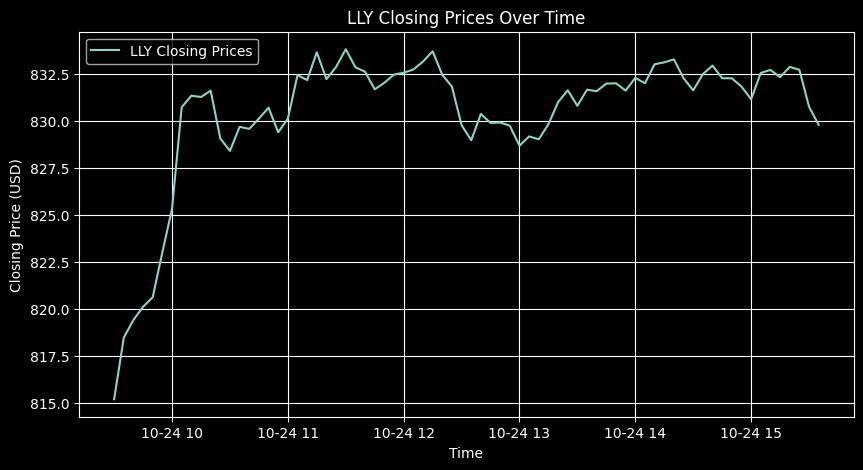

In [51]:
# Plot ts_lly using matplotlib, use a nice dark theme
matplt.style.use('dark_background')
matplt.figure(figsize=(10, 5))
matplt.plot(ts_lly[0], ts_lly[1], label='LLY Closing Prices')
matplt.title('LLY Closing Prices Over Time')
matplt.xlabel('Time')
matplt.ylabel('Closing Price (USD)')
matplt.legend()
matplt.grid(True)
matplt.show()

# Short-term signal processing: Savitzky–Golay, Butterworth, FFT
In this lesson we implement three short-term signal-processing techniques:

- Savitzky–Golay smoothing (preserves local features)
- Butterworth lowpass filtering (IIR, smooth frequency cutoff)
- FFT power spectrum of returns (spectral analysis)

We'll fetch intraday data using `timeseries.get_time_series`, apply filters, and visualize results with `matplotlib`. If you need packages, install: `pip install scipy numpy matplotlib`.

## Savitzky–Golay smoothing — theory and intuition
Savitzky–Golay (S-G) smoothing fits a low-degree polynomial to a moving window of the data using least-squares and replaces the central point with the polynomial value.
Advantages: preserves peak height and width better than a simple moving average and has low phase distortion.
Key parameters: window length (odd integer) and polynomial order. Avoid a window longer than the structure you want to preserve.

### Intuitive Example

The Problem: The Jiggly Treasure Map
Imagine you and your friend, Alex, are on a treasure hunt. You have a special GPS device that gives you your exact latitude every minute. The final clue is: "Walk precisely North until the slope of your path is exactly zero."

You start walking and record your latitude over time. You expect a nice, smooth, upward trend. But when you plot the data, it looks like this:

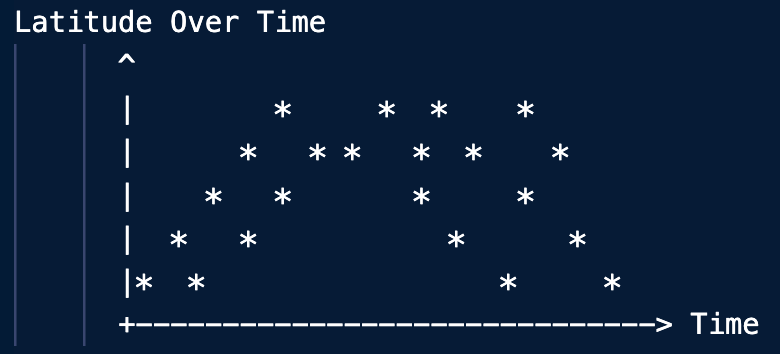

The Problem: Your GPS is a bit cheap and has a lot of "jiggle" (noise). The signal is fundamentally there—you are walking North—but the random jiggles make it impossible to tell if you're on a flat plateau. Calculating the slope (the derivative) from one noisy point to the next is meaningless; it would be a chaotic, jiggly mess.

Your First (Bad) Idea: The "Brute Force" Moving Average
You think, "I'll just smooth out the jiggles!" You take a simple 5-point moving average. For each point, you replace it with the average of itself and its two neighbors on either side.

The result is smoother, but you've created a new problem! Your map now looks like this:

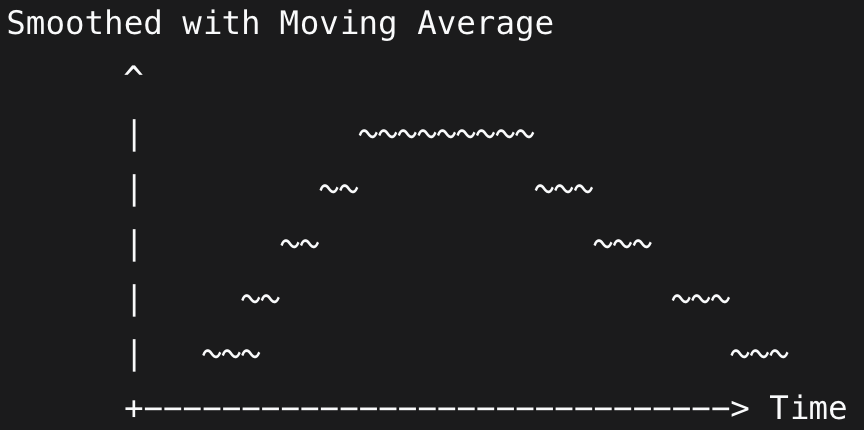

You've smoothed the data, but you've also blurred it. The sharp, flat plateau you were looking for has been turned into a soft, rolling hill. The moving average acts like a low-pass filter, butchering the very feature (the sharp transition to a flat slope) you need to detect. It's like using a sledgehammer to swat a fly—you get rid of the noise, but you also damage the delicate structure of the signal.

The Solution: The Savitzky-Golay "Shape-Preserving" Glasses
This is where Savitzky-Golay (SG) smoothing comes to the rescue. You explain it to Alex like this:

"Instead of just mashing our data points together with an average, let's be smarter. Let's take a small window of points, say 5 points at a time, and fit a tiny, best-fit polynomial curve through them."

How it works:

1. You slide a 5-point window over your jiggly data.

2. For each window, you ask: "What is the smoothest, simplest curve (e.g., a parabola) that generally fits these 5 noisy points?"

3. You then replace the central point of the window with the value of that best-fit polynomial.

4. You then slide the window forward one point and repeat.

The result looks like this:

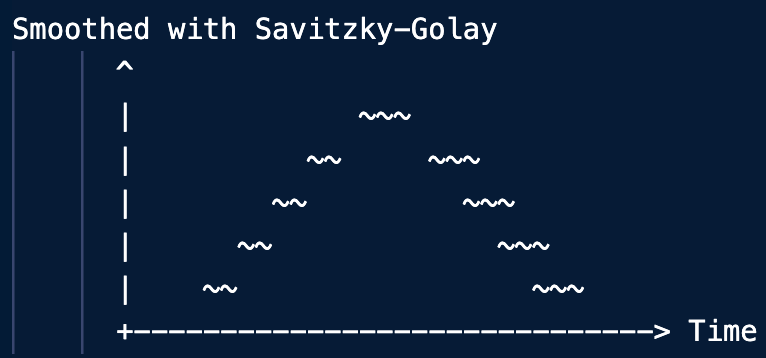

Why it's a better solution:

- It Kills the Jiggle: The random noise is effectively smoothed out because the polynomial ignores the random jiggles and follows the underlying trend.

- It Preserves the Shape: Unlike the moving average, which butchered the plateau, the polynomial is much better at preserving the sharp features. The flat, zero-slope region remains much flatter and more distinct. This is because a polynomial is a more sophisticated model of the underlying signal than a simple mean.




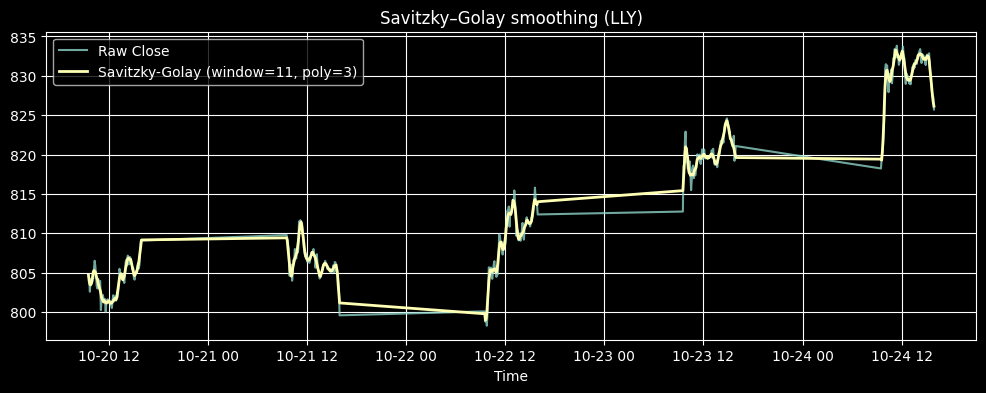

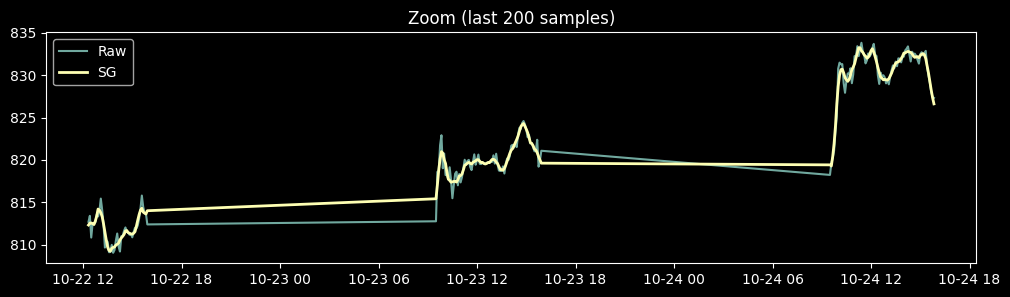

In [55]:
# Savitzky–Golay example (uses scipy)
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

# Fetch a slightly larger intraday window to have enough points
ticker = yf.Ticker('LLY')
dates, o, h, l, close, volume = ts.get_time_series(ticker, period='5d', interval='5m')
times = dates

# Determine an odd window length based on series length (cap to reasonable value)
win = 11 if len(close) >= 11 else (len(close) // 2) * 2 + 1
poly = 3 if win > 3 else 1
sg = savgol_filter(close, window_length=win, polyorder=poly)

# Plot raw vs smoothed
plt.style.use('dark_background')
plt.figure(figsize=(12, 4))
plt.plot(times, close, label='Raw Close', alpha=0.8)
plt.plot(times, sg, label=f'Savitzky-Golay (window={win}, poly={poly})', linewidth=2)
plt.title('Savitzky–Golay smoothing (LLY)')
plt.xlabel('Time')
plt.legend()
plt.grid(True)
plt.show()

# Show a small zoomed-in window to inspect preservation of features
if len(close) > 200:
    s, e = -200, -1
    plt.figure(figsize=(12, 3))
    plt.plot(times[s:e], close[s:e], alpha=0.8, label='Raw')
    plt.plot(times[s:e], sg[s:e], label='SG', linewidth=2)
    plt.title('Zoom (last 200 samples)')
    plt.legend()
    plt.show()

## Butterworth lowpass filter — theory and intuition
Butterworth filters are IIR filters designed to have a maximally flat passband. When applied with zero-phase filtering (`filtfilt`) they remove high-frequency noise while avoiding phase shift.
Key parameters: filter order and cutoff frequency (as normalized frequency or with `fs`). Use `filtfilt` to avoid delay. Beware of edge effects and required minimum length for padding.

### Intuitive Problem

Imagine you're a master sound engineer, and you've been given a priceless historical recording: a beautiful, soft violin solo from a century ago. The problem is, it was recorded on primitive equipment and is now full of high-frequency hiss and scratchiness (think of the sound of an old vinyl record).

Your goal is to remove the annoying hiss while preserving the pure, warm tone of the violin as perfectly as possible.

Your First (Bad) Idea: The "Brick Wall" Filter
You reach for a simple, aggressive low-pass filter. It works by brutally cutting off all frequencies above a certain point.

The result is... disappointing. The hiss is gone, but so is the soul of the music. The violin now sounds like it's being played from underwater:

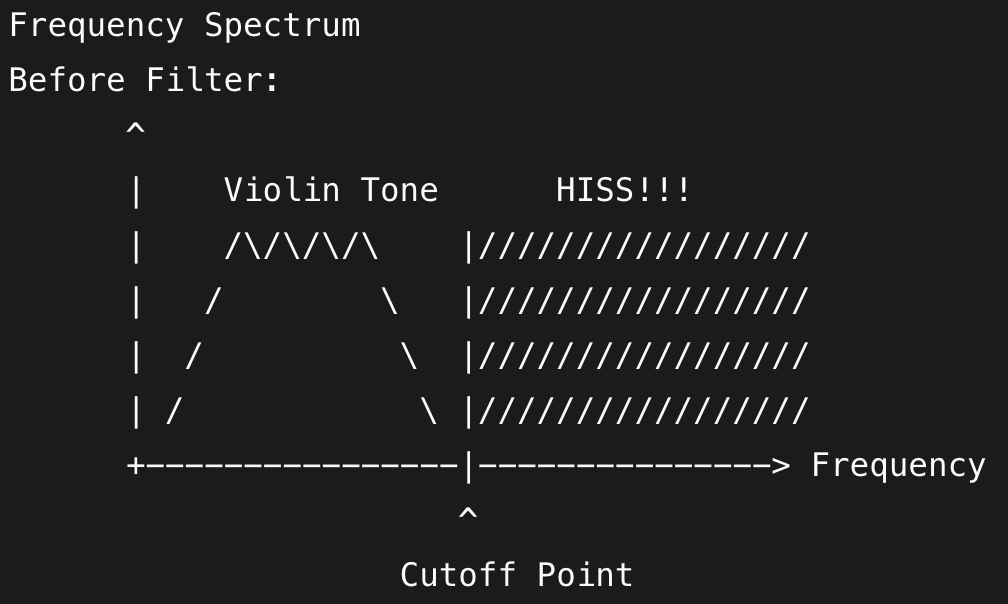
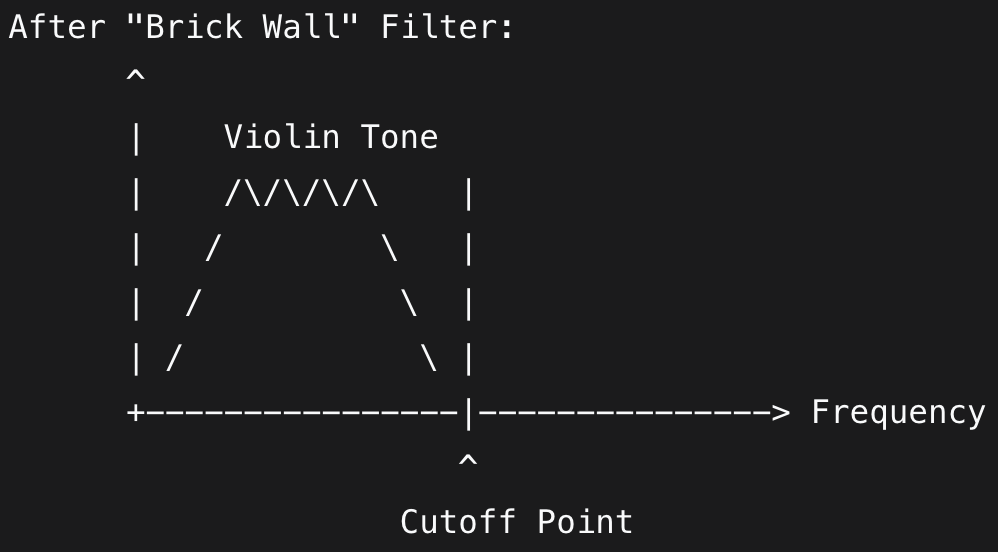

The violin sounds muffled and dull. Why? Because the sharp cut-off of the filter also removed the delicate high harmonics of the violin—the very frequencies that give it its brilliance, clarity, and "air." The filter introduced something called "ringing" artifacts, meaning it added a subtle, unnatural wobble to the sound every time the violin played a sharp note. It was like trying to sculpt with a chainsaw.

The Solution: The Butterworth "Velvet Rope"
This is where the Butterworth low-pass filter shines. You explain it to your assistant like this:

"Instead of a brick wall, we need a 'velvet rope.' We want to gently but firmly tell the high-frequency hiss it's not allowed in, without manhandling the precious violin tones that are right next to it in line."

How it works:

The Butterworth filter is designed with one golden rule: have a frequency response that is as flat as possible in the passband.

1. Maximally Flat Passband: In the range of frequencies we want to keep (the low frequencies of the violin), the Butterworth filter does almost nothing to them. It doesn't boost or cut; it just lets them through exactly as they are. This preserves the natural, warm character of the instrument.

2. Smooth, Gradual Roll-off: After the "cutoff frequency," it doesn't just stop. It creates a very smooth, gentle slope downwards into the stopband.

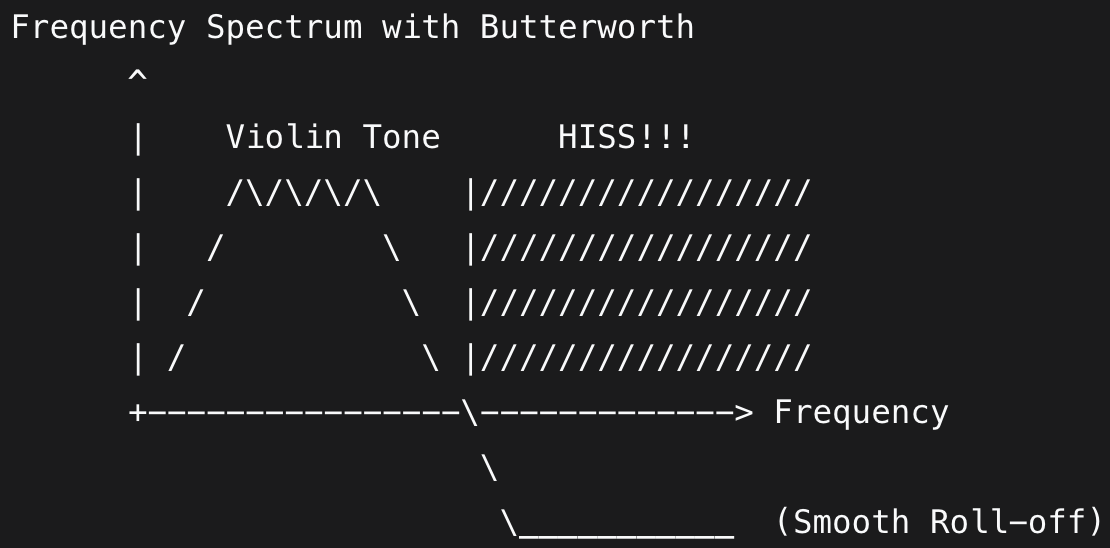

Why it's a better solution:

- Preserves the True Sound: Because the passband is so flat, the violin's tone remains completely intact and undistorted. You lose none of its warmth or character.

- No Ringing: The smooth, gradual transition (instead of a sharp cut) means there are no nasty "ringing" artifacts in the time domain. The music sounds natural, even after being filtered.

- It's a Compromise: It perfectly balances the two things we care about: preserving the desired signal and removing the noise. It's not the sharpest filter available, but it's the one that introduces the fewest unpleasant side effects.



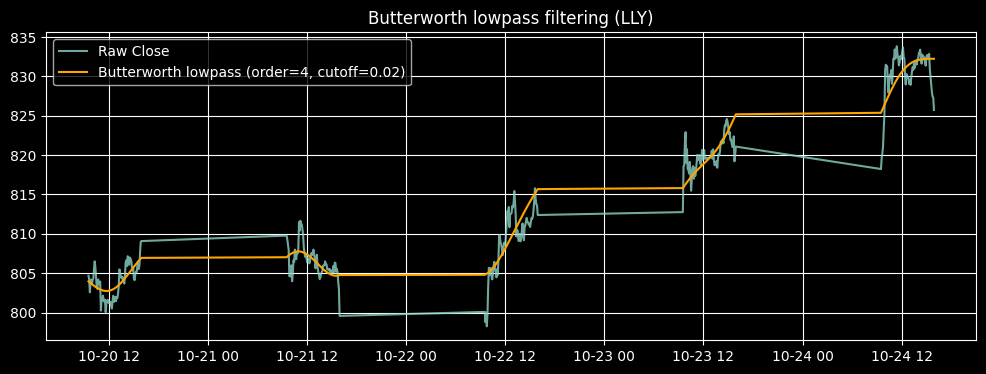

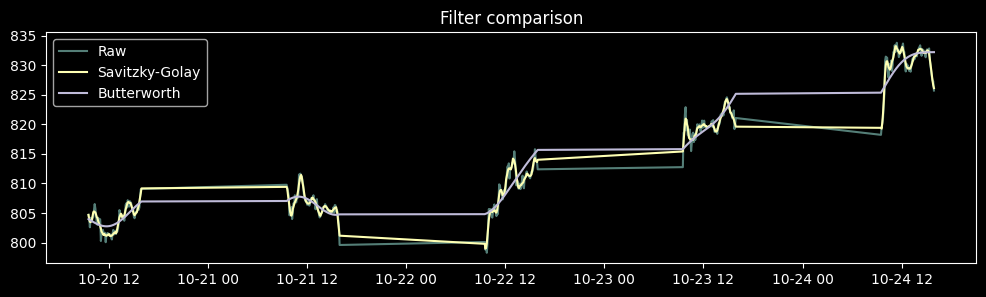

In [57]:
from scipy.signal import butter, filtfilt
import numpy as np
import matplotlib.pyplot as plt

# Use same data as above (if not present, fetch)
try:
    close
except NameError:
    ticker = yf.Ticker('LLY')
    dates, o, h, l, close, volume = ts.get_time_series(ticker, period='5d', interval='5m')
    times = dates

# Design Butterworth lowpass: order and normalized cutoff (0..1 where 1 -> Nyquist)
order = 4
# Example cutoff: keep very low-frequency components; adjust as needed.
cutoff_norm = 0.02
b, a = butter(order, cutoff_norm, btype='low', analog=False)
# filtfilt for zero-phase
# Ensure we have enough samples for filtfilt padding; otherwise fallback to lfilter
butt = None
try:
    butt = filtfilt(b, a, close)
except Exception as e:
    # fallback: if filtfilt fails due to short signal, use lfilter (has phase delay)
    from scipy.signal import lfilter
    butt = lfilter(b, a, close)

plt.style.use('dark_background')
plt.figure(figsize=(12, 4))
plt.plot(times, close, label='Raw Close', alpha=0.8)
plt.plot(times, butt, label=f'Butterworth lowpass (order={order}, cutoff={cutoff_norm})', color='orange')
plt.title('Butterworth lowpass filtering (LLY)')
plt.legend()
plt.grid(True)
plt.show()

# Compare SG and Butterworth on same axes if available
if 'sg' in globals():
    plt.figure(figsize=(12, 3))
    plt.plot(times, close, alpha=0.6, label='Raw')
    plt.plot(times, sg, label='Savitzky-Golay', linewidth=1.5)
    plt.plot(times, butt, label='Butterworth', linewidth=1.5)
    plt.title('Filter comparison')
    plt.legend()
    plt.show()

## FFT power spectrum of returns — theory and intuition
The Fourier transform decomposes a time series into frequency components. For financial returns, the power spectrum can highlight dominant cycles (if any) and help choose filter cutoff frequencies.
Important notes: returns should be stationary; use log-returns or demeaned returns and interpret frequencies in cycles per sample (convert to cycles/day using sampling rate). Use windowing to reduce spectral leakage.

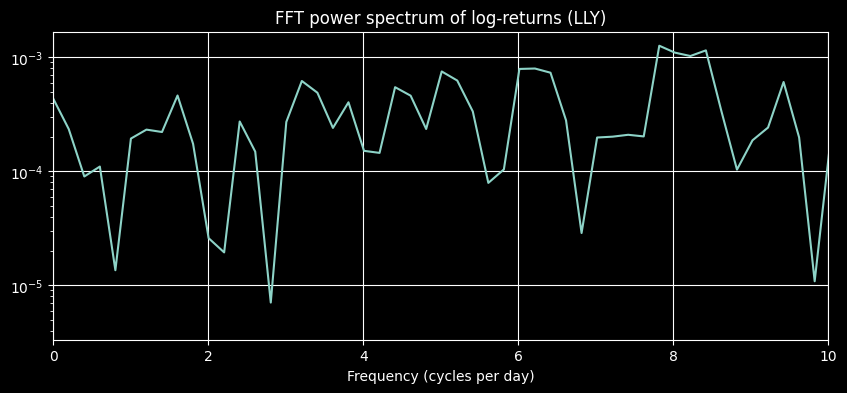

Top frequency peaks (cycles/day, power):
7.820  1.2615e-03
11.630  1.2115e-03
29.676  1.1905e-03
8.422  1.1484e-03
29.877  1.1447e-03


In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import windows

# Prepare returns (log-returns)
try:
    close
except NameError:
    ticker = yf.Ticker('LLY')
    dates, o, h, l, close, volume = ts.get_time_series(ticker, period='5d', interval='5m')

returns = np.diff(np.log(close + 1e-12))  # tiny eps to avoid zeros
n = len(returns)
if n < 4:
    print('Not enough points for FFT, fetch a longer series (e.g., 30d).')
else:
    # apply a Hann window to reduce leakage
    win = windows.hann(n)
    returns_win = returns * win
    fft_vals = np.fft.rfft(returns_win)
    ps = np.abs(fft_vals)**2
    freqs = np.fft.rfftfreq(n, d=1)  # cycles per sample
    # convert to cycles per day assuming 5-min bars (~78 samples/day)
    samples_per_day = int(6.5 * 60 / 5)
    freqs_per_day = freqs * samples_per_day

    plt.style.use('dark_background')
    plt.figure(figsize=(10, 4))
    plt.semilogy(freqs_per_day, ps, label='Power')
    plt.xlim(0, 10)
    plt.xlabel('Frequency (cycles per day)')
    plt.title('FFT power spectrum of log-returns (LLY)')
    plt.grid(True)
    plt.show()

    # Optionally show normalized power and dominant peaks
    peak_idx = np.argsort(ps)[-5:][::-1]
    peaks = list(zip(freqs_per_day[peak_idx], ps[peak_idx]))
    print('Top frequency peaks (cycles/day, power):')
    for f, p in peaks:
        print(f'{f:.3f}  {p:.4e}')

### Notes and next steps
- Experiment with window sizes and cutoff frequencies; evaluate filter effect on one-step-ahead forecast error.
- Use FFT results to inform Butterworth cutoff choices.
- Next lessons will cover Kalman filters and wavelet denoising (mid-term).